# Colocalization analysis

Shows colocalization results for all figures in the manuscripts.

Usage:
* Sections Initialization, General parameters ... and Read colocalization ... have to be executed first, in order
* Cells from other sections show graphs, they can be executed in any order

Reads data:
* Particle patterns in particles/
* Colocalization results in coloc/

### Pattern and colocalization names

Particle sets A, B and C here correspond to sets P, Q and R in the manuscript.

Pattern names:
* ARandom[Full, 08, 06, 05]: Randomly distributed particle set A on the entire area, 80%, 60% an 50% of the entire area, respectively
* ARandom[ExclFull, Extend2]:  Randomly distributed particle set A with particle exclusion distance and on an extended area, respectively
* BrfCoclustAr[area_A]p[fraction_points_A][variant]-pkd-d[interaction_distance]: Set B that locally interacts with set A in 1-to-1 mode, where
  - area_A: (f, 08, 06, 05) Area over which A is distributed (full, 80%, 60% and 50%) respectively
  - fraction_points_A: (03, 02, 015, ...) Fraction of points in A that are involved in the interaction (03, 0.2, 0.15, ..., respectively)
  - variant (used only for 3-colocalizations): ('k', '') Common and independent interacting subset variants, respectively 
  - interaction_distance: (5, 10, 15) Interaction distance in pixels
* BrfCoclustAr[area_A]p[fraction_points_A]-p[fraction_points_B]-d[interaction_distance]: Set B that locally interacts with set A in multimeric mode (like 1-to-1 mode, except that fraction of interacting points is specified separately for the two sets)

Colocalization names:
* Composed of pattern names specified in the colocalization order and separated by '_'
* For example:
    - CRandom06_ARandomFull: 2-colocalization, univariate clustering
    - ARandomFull_BrfCoclustArfp01k-pkd-d10_CrfCoclustArfp01k-pkd-d10: 3-colocalization, local interactions 1-to-1 mode, common interacting subset variant

## Initialization

In [1]:
import os
import sys
import pathlib

import numpy as np
import scipy as sp
import pandas as pd 

import pyto
from pyto.io.pandas_io import PandasIO
import pyto.spatial.point_pattern as point_pattern
import pyto.spatial.coloc_functions as col_func
import pyto.spatial.coloc_plot as col_plot
import pyto.spatial.coloc_theory as coloc_theory
from pyto.spatial.particle_sets import ParticleSets
from pyto.spatial.multi_particle_sets import MultiParticleSets
from pyto.spatial.coloc_plot import plot_p, plot_32_p, plot_data, plot_32_data
from pyto.spatial.coloc_plot import plot_multiple
from pyto.spatial.coloc_lite import ColocLite

# matplotlib 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# common
import common
from common import n_A, n_B, n_C, pixel_size_nm
from common import rectangle_50_area, rectangle_05_area, rectangle_06_area
from common import rectangle_08_area, rectangle_full_area
from common import rectangle_05w_05e_over, rectangle_05sw_05ne_over
from common import rectangle_06w_06e_over, rectangle_06sw_06ne_over

# convenience
#import ipdb
%autosave 0
sys.version

Autosave disabled


'3.13.3 | packaged by conda-forge | (main, Apr 14 2025, 20:44:03) [GCC 13.3.0]'

In [2]:
# Settings

# force showing all rows in a table (default 60 rows)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# use tex
plt.rcParams['text.usetex'] = True

# set hostname
hostname = os.uname()[1]
print(f"Host: {hostname}")

Host: rauna


### Setup figures 

In [3]:
# Useful functions for figures

# set plot parameters
def set_plot(plot_type):
    
    # for making figures 
    if plot_type == 'figure_save':
        # for some reason need to repeat
        %matplotlib qt
        plt.rcParams['font.size'] = 16  
        %matplotlib qt
        plt.rcParams['font.size'] = 16
        plt.rcParams['lines.linewidth'] =  1
    
    # figure-like inline
    if plot_type == 'figure_inline':
        %matplotlib inline
        plt.rcParams['font.size'] = 16
    
    # standard inline
    if plot_type == 'inline':
        %matplotlib inline
        plt.rcParams["figure.figsize"] = [4.5, 3]


In [4]:
# choose figure type, uncomment one
#plot_type = 'figure_save' 
#plot_type = 'figure_inline'
plot_type = 'inline'

set_plot(plot_type)

# directory to save plots (only if plot_type = 'figure_save')
plot_root = os.path.join(
    pathlib.Path.home(), 
    'some_colocalization_dir/graphs/')

## General parameters and definitions

Important: Have to be the same as defined in make_patterns.ipynb and analyze_colocalizations.ipynb

In [5]:
# General params

# path to particles (patterns) table
mps_path = 'particles/mps.pkl'

# colocalization distance [nm]
distance = np.arange(1, 31)

# N simulations
n_simul = 20

# colocalization name mode
name_mode = '_'

In [6]:
colors = {'A': 'm', 'B': 'c', 'C': 'y'}

def plot_pattern(
    mps, names, ranges=None, x_col=None, y_col=None, legend=True, 
    colors=None, xlim=(100, 500), ylim=(200, 400), ax=None, 
    markersize=5, **plot_kw):
    """Makes one plot that may contain multiple patterns.
    """

    if x_col is None:
        x_col = 'x_reg_frame'
    if y_col is None:
        y_col = 'y_reg_frame'
    if ax is None:
        fig, ax = plt.subplots()
    for ind, nam in enumerate(names):
        if colors is None:
            col = f'C{ind}'
        elif isinstance(colors, (list, tuple)):
            col = colors[ind]
        elif isinstance(colors, dict):
            col = colors[nam[0]]
        if ranges is None or ranges[ind] is None:
            (mps.particles
                .query("subclass_name == @nam")
                .plot(kind='scatter', x=x_col, y=y_col, color=col, 
                      legend=True, ax=ax, s=markersize, **plot_kw)
            )
        else:
            (mps.particles
                .query("subclass_name == @nam")
                .iloc[range(*ranges[ind])]
                .plot(kind='scatter', x=x_col, y=y_col, color=col, 
                      legend=True, ax=ax, s=markersize, **plot_kw)
            )
    if legend:
        ax.legend(names)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('')
    ax.set_ylabel('')
        
    return ax

## Read colocalizations and particles

In [7]:
# Read colocalization results
# has to be executed every time

col = ColocLite.read_table_multi(
    names=None, dir_='coloc', mode=name_mode, verbose=False)

In [8]:
# Read particles
# needed to calculate colocalizations of the fly, but not to show colocalizations

mps = MultiParticleSets.read(mps_path)

Read  MPS object particles/mps.pkl


## Random

### Figures

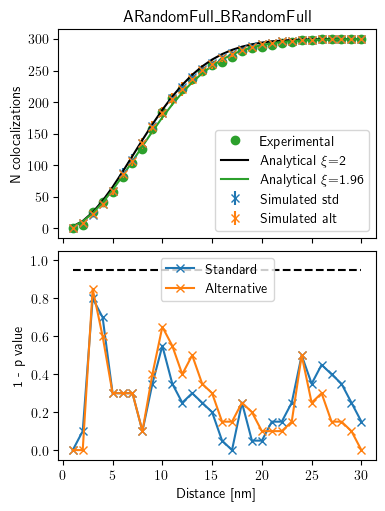

In [9]:
names = ['ARandomFull_BRandomFull']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True)#,
    #linewidth=1)

AFull_BFull = coloc_theory.coloc_random(
    distance=distance, N=(n_A, n_B), A=(rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=2)

axes[0, 0].plot(distance, AFull_BFull, '-', color='k', label=r'Analytical $\xi$=2')
AFull_BFull_ndim = coloc_theory.coloc_random(
    distance=distance, N=(n_A, n_B), A=(rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=1.96)
axes[0, 0].plot(
    distance, AFull_BFull_ndim, '-', color='C2', label=r'Analytical $\xi$=1.96')

axes[0, 0].set_ylabel('N colocalizations') 
axes[0, 0].set_title(names[0])
leg = axes[0, 0].legend()
leg.get_texts()[0].set_text('Experimental')
leg.get_texts()[3].set_text('Simulated std')
leg.get_texts()[4].set_text('Simulated alt')
axes[1, 0].set_title("")
leg = axes[1, 0].legend()
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[1, 0].set_title("")
    axes[0, 0].set_ylabel('N colocalizations')
    #axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'random_univariate/AB_3.svg')

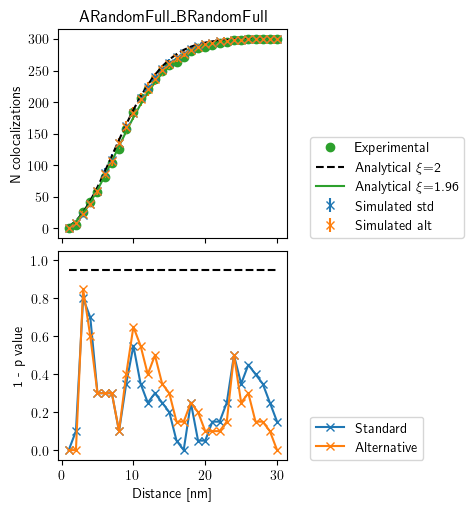

In [10]:
# only used for legends

names = ['ARandomFull_BRandomFull']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);

AFull_BFull = coloc_theory.coloc_random(
    distance=distance, N=(n_A, n_B), A=(rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=2)

axes[0, 0].plot(distance, AFull_BFull, '--', color='k', label=r'Analytical $\xi$=2')
AFull_BFull_ndim = coloc_theory.coloc_random(
    distance=distance, N=(n_A, n_B), A=(rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=1.96)
axes[0, 0].plot(
    distance, AFull_BFull_ndim, '-', color='C2', label=r'Analytical $\xi$=1.96')

axes[0, 0].set_ylabel('N colocalizations') 
axes[0, 0].set_title(names[0])
leg = axes[0, 0].legend(loc=(1.1, 0))
leg.get_texts()[0].set_text('Experimental')
leg.get_texts()[3].set_text('Simulated std')
leg.get_texts()[4].set_text('Simulated alt')
axes[1, 0].set_title("")
leg = axes[1, 0].legend(loc=(1.1, 0))
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[1, 0].set_title("")
    axes[0, 0].set_ylabel('N colocalizations')
    #axes[1, 1].set_ylabel('')
    #axes[0, 0].get_legend().remove()
    #axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'random_univariate/AB_legend.svg')

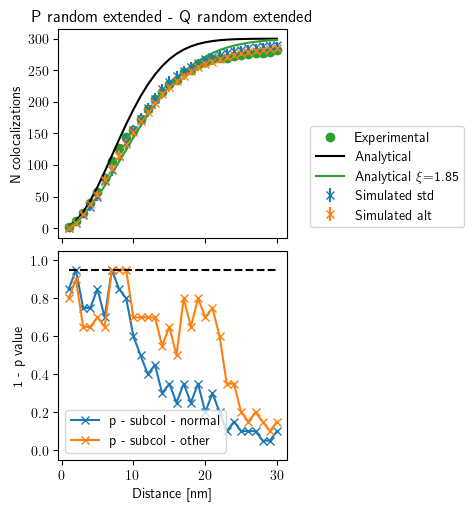

In [11]:
names = ['ARandomExtend2_BRandomExtend2']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);

AFull_BFull = coloc_theory.coloc_random(
    distance=distance, N=(n_A, n_B), A=(rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=2)
axes[0, 0].plot(distance, AFull_BFull, '-', color='k', label='Analytical')

AFull_BFull_ndim = coloc_theory.coloc_random(
    distance=distance, N=(n_A, n_B), A=(rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=1.85)
axes[0, 0].plot(
    distance, AFull_BFull_ndim, '-', color='C2', label=r'Analytical $\xi$=1.85')
axes[0, 0].legend();

axes[0, 0].set_ylabel('N colocalizations') 
axes[0, 0].set_title("P random extended - Q random extended")
leg = axes[0, 0].legend(loc=(1.1, 0.05))
leg.get_texts()[0].set_text('Experimental')
leg.get_texts()[3].set_text('Simulated std')
leg.get_texts()[4].set_text('Simulated alt')
#leg_01 = axes[0, 1].legend()
#leg_01[0].set_text('Experimental')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    #axes[0, 1].set_title('')
    axes[1, 0].set_title("")
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'random_univariate/AB_extend.svg')

### Particles

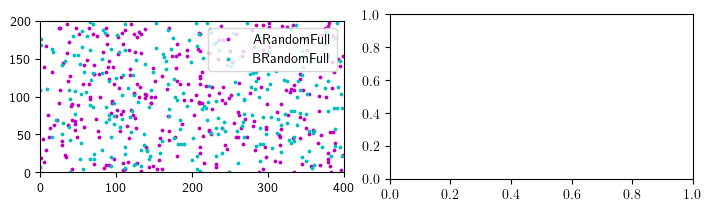

In [12]:
# Right graph intentionaly empty

pattern_names = [
    ('ARandomFull', 'BRandomFull'), ('ARandomFull', 'BRandomFull')]

xlim=(100, 500)
ylim=(200, 400)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
for ax, pattern_nam in zip(axes, pattern_names):
    _ = plot_pattern(
        mps=mps, names=pattern_nam, ax=ax, xlim=xlim, ylim=ylim,
        colors=colors, markersize=3)
    
    ax.set_xticks(ax.get_xticks(), ax.get_xticks().astype(int) - xlim[0])
    ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int) - ylim[0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')
    break

if plot_type == 'figure_save':
    axes[0].get_legend().remove()
    plt.savefig(
        plot_root + 'random_univariate/A-B_particles.pdf', bbox_inches='tight')

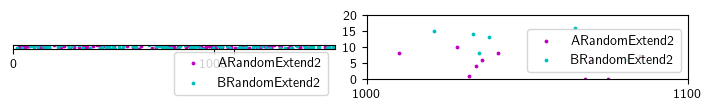

In [13]:

pattern_names = [
    ('ARandomExtend2', 'BRandomExtend2'), ('ARandomExtend2', 'BRandomExtend2')]

xlim=(0, 1600)
ylim=(100, 120)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
for ax, pattern_nam in zip(axes, pattern_names):
    ax = plot_pattern(
        mps=mps, names=pattern_nam, ax=ax, xlim=xlim, ylim=ylim,
        colors=colors, markersize=3)
    
axes[0].set_xticks(axes[0].get_xticks(), axes[0].get_xticks().astype(int) - xlim[0])
axes[0].set_xticks([0, 1000, 1100])
axes[0].set_yticks([])
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
axes[0].set_aspect('equal', adjustable='box')

xlim=(1000, 1100)
ylim=(100, 120)
axes[1].set_xticks(axes[1].get_xticks(), axes[1].get_xticks().astype(int) - 0)
axes[1].set_yticks(axes[1].get_yticks(), axes[1].get_yticks().astype(int) - ylim[0])
axes[1].set_xticks([1000, 1100])
axes[1].set_xticks([1000, 1100], ['1000', '1100'])
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)
axes[1].set_aspect('equal', adjustable='box')

if plot_type == 'figure_save':
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    plt.savefig(
        plot_root + 'random_univariate/A-B_extend_particles.pdf', bbox_inches='tight')

## Univariate

### Figures

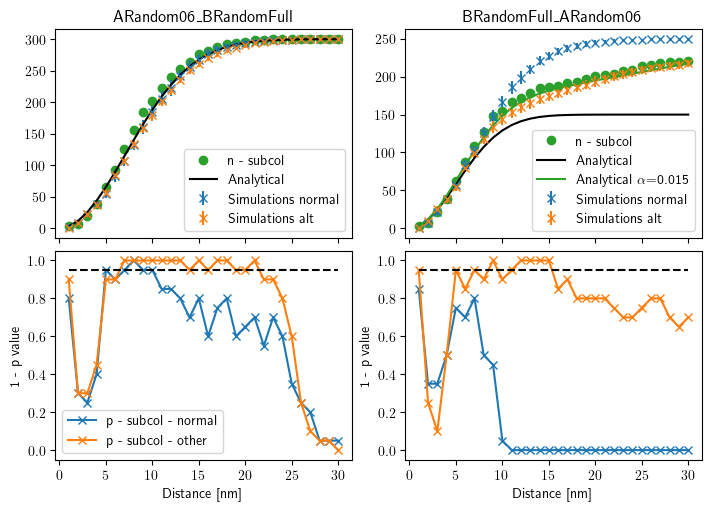

In [14]:
names = ['ARandom06_BRandomFull', 'BRandomFull_ARandom06']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True)

A06_BFull = coloc_theory.coloc_random(
    distance=distance, N=(n_A, n_B), A=(rectangle_06_area, rectangle_full_area), 
    A_over=rectangle_06_area, ndim=2, over_factor=0.0)
axes[0, 0].plot(distance, A06_BFull, '-', color='k', label='Analytical')
axes[0, 0].legend();

BFull_A06 = coloc_theory.coloc_random(
    distance=distance, N=(n_B, n_A), A=(rectangle_full_area, rectangle_06_area), 
    A_over=rectangle_06_area, ndim=2, over_factor=0.0)
axes[0, 1].plot(distance, BFull_A06, '-', color='k', label=r'Analytical')
BFull_A06 = coloc_theory.coloc_random(
    distance=distance, N=(n_B, n_A), A=(rectangle_full_area, rectangle_06_area), 
    A_over=rectangle_06_area, ndim=2, over_factor=0.015)
axes[0, 1].plot(
    distance, BFull_A06, '-', color='C2', label=r'Analytical $\alpha$=0.015')
axes[0, 1].legend();

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[0, 1].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'random_univariate/A06_B.svg')

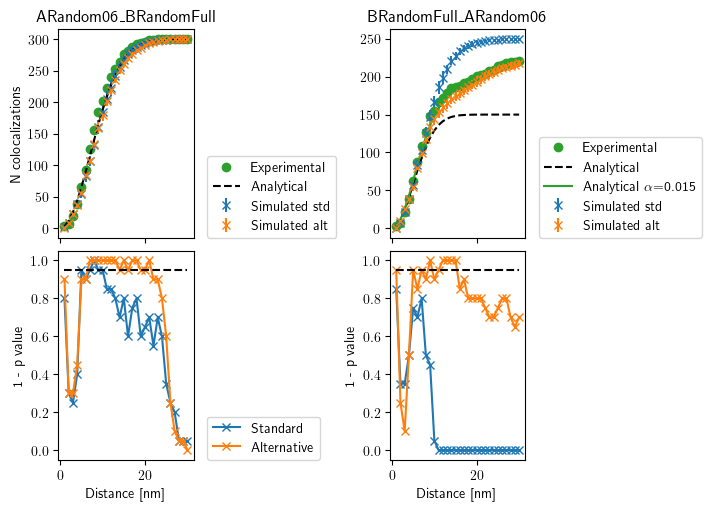

In [15]:
# Legend

names = ['ARandom06_BRandomFull', 'BRandomFull_ARandom06']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True)

A06_BFull = coloc_theory.coloc_random(
    distance=distance, N=(n_A, n_B), A=(rectangle_06_area, rectangle_full_area), 
    A_over=rectangle_06_area, ndim=2, over_factor=0.0)
axes[0, 0].plot(distance, A06_BFull, '--', color='k', label='Analytical')
axes[0, 0].legend();

BFull_A06 = coloc_theory.coloc_random(
    distance=distance, N=(n_B, n_A), A=(rectangle_full_area, rectangle_06_area), 
    A_over=rectangle_06_area, ndim=2, over_factor=0.0)
axes[0, 1].plot(distance, BFull_A06, '--', color='k', label=r'Analytical')
BFull_A06 = coloc_theory.coloc_random(
    distance=distance, N=(n_B, n_A), A=(rectangle_full_area, rectangle_06_area), 
    A_over=rectangle_06_area, ndim=2, over_factor=0.015)
axes[0, 1].plot(
    distance, BFull_A06, '-', color='C2', label=r'Analytical $\alpha$=0.015')
axes[0, 1].legend();

axes[0, 0].set_ylabel('N colocalizations') 
axes[0, 0].set_title(names[0])
leg = axes[0, 0].legend(loc=(1.1, 0))
leg.get_texts()[0].set_text('Experimental')
leg.get_texts()[2].set_text('Simulated std')
leg.get_texts()[3].set_text('Simulated alt')
leg = axes[0, 1].legend(loc=(1.1, 0))
leg.get_texts()[0].set_text('Experimental')
leg.get_texts()[3].set_text('Simulated std')
leg.get_texts()[4].set_text('Simulated alt')
axes[1, 0].set_title("")
leg = axes[1, 0].legend(loc=(1.1, 0))
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    #axes[0, 0].get_legend().remove()
    #axes[0, 1].get_legend().remove()
    #axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'random_univariate/A06_B_legend.svg')

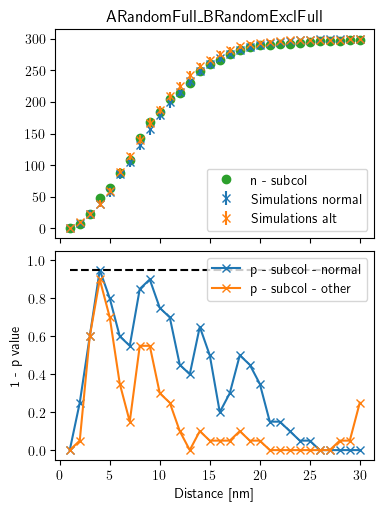

In [16]:
names = ['ARandomFull_BRandomExclFull']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'random_univariate/A_Bexcl.svg')

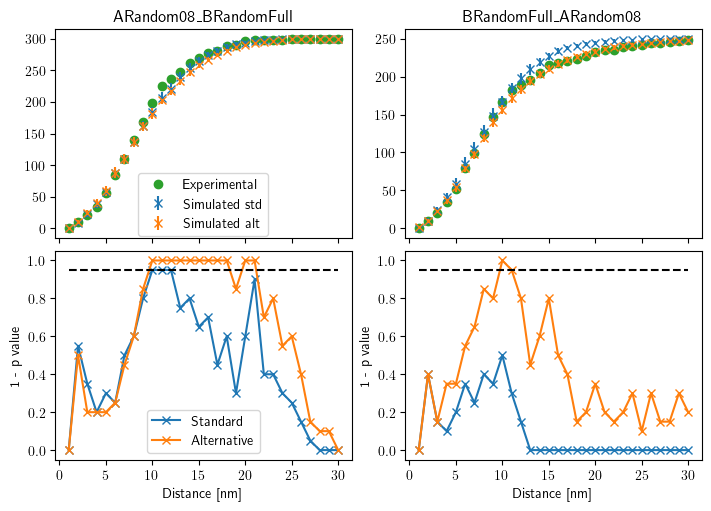

In [17]:
names = ['ARandom08_BRandomFull', 'BRandomFull_ARandom08']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);

leg = axes[0, 0].legend(loc=(0.28, 0.01))
leg_texts = leg.get_texts()
leg_texts[0].set_text('Experimental')
#leg_texts[1].set_text('Analytical')
leg_texts[1].set_text('Simulated std')
leg_texts[2].set_text('Simulated alt')
leg = axes[1, 0].legend()
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'random_univariate/A08_B.svg')

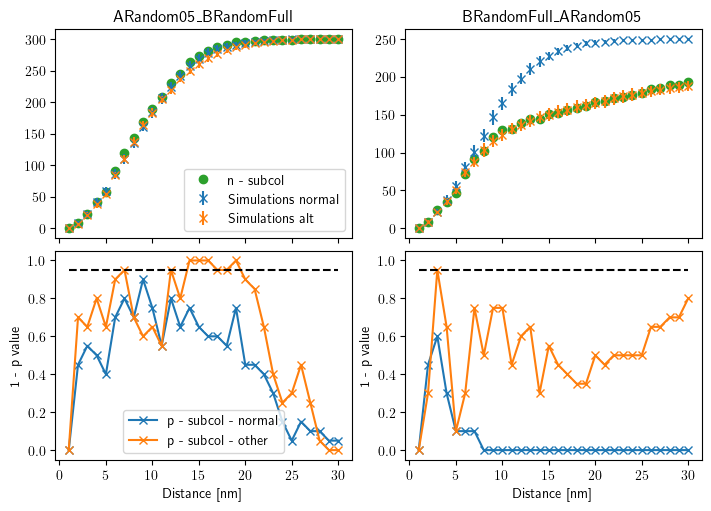

In [18]:
names = ['ARandom05_BRandomFull', 'BRandomFull_ARandom05']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'random_univariate/A05_B.svg')

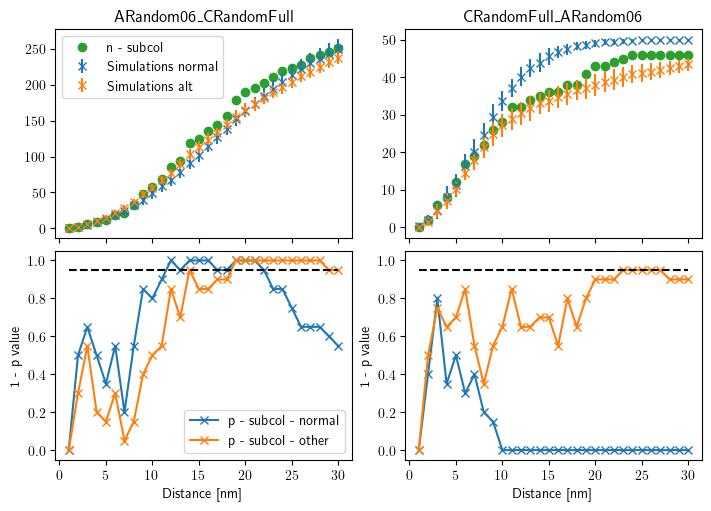

In [19]:
names = ['ARandom06_CRandomFull', 'CRandomFull_ARandom06']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'random_univariate/A06_C.svg')

### Particles

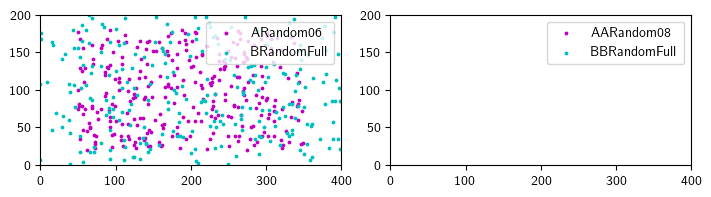

In [20]:
# Right graph intentionaly empty

pattern_names = [
    ('ARandom06', 'BRandomFull'), 
    ('AARandom08', 'BBRandomFull')]

xlim=(100, 500)
ylim=(200, 400)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
for ax, pattern_nam in zip(axes, pattern_names):
    _ = plot_pattern(
        mps=mps, names=pattern_nam, ax=ax, xlim=xlim, ylim=ylim,
        colors=colors, markersize=3)
    
    ax.set_xticks(ax.get_xticks(), ax.get_xticks().astype(int) - xlim[0])
    ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int) - ylim[0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')

if plot_type == 'figure_save':
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    plt.savefig(
        plot_root + 'random_univariate/A06-B_particles.pdf', bbox_inches='tight')

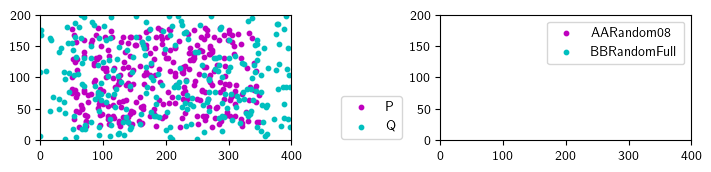

In [21]:
# For legend only
pattern_names = [
    ('ARandom06', 'BRandomFull'), 
    ('AARandom08', 'BBRandomFull')]

xlim=(100, 500)
ylim=(200, 400)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
for ax, pattern_nam in zip(axes, pattern_names):
    _ = plot_pattern(
        mps=mps, names=pattern_nam, ax=ax, xlim=xlim, ylim=ylim,
        colors=colors, markersize=10)
    
    ax.set_xticks(ax.get_xticks(), ax.get_xticks().astype(int) - xlim[0])
    ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int) - ylim[0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')

leg = axes[0].legend(['P', 'Q'], loc=(1.2, 0.01))

if plot_type == 'figure_save':
    #xes[0].get_legend().remove()
    axes[1].get_legend().remove()
    plt.savefig(
        plot_root + 'random_univariate/A06-B_particles_legend.pdf', bbox_inches='tight')

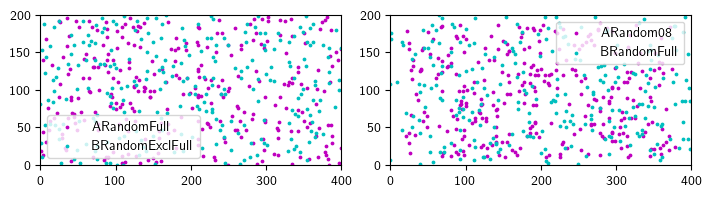

In [22]:

pattern_names = [
    ('ARandomFull', 'BRandomExclFull'), 
    ('ARandom08', 'BRandomFull')]

xlim=(100, 500)
ylim=(200, 400)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
for ax, pattern_nam in zip(axes, pattern_names):
    _ = plot_pattern(
        mps=mps, names=pattern_nam, ax=ax, xlim=xlim, ylim=ylim,
        colors=colors, markersize=3)
    
    ax.set_xticks(ax.get_xticks(), ax.get_xticks().astype(int) - xlim[0])
    ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int) - ylim[0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')

if plot_type == 'figure_save':
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    plt.savefig(
        plot_root + 'random_univariate/A-Bexcl_A08-B.pdf', bbox_inches='tight')

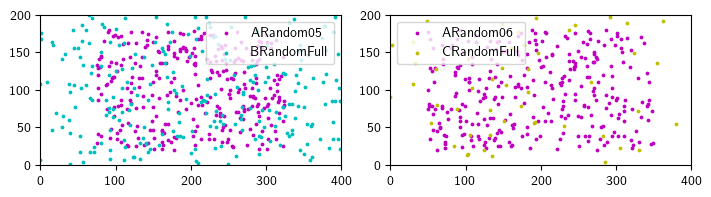

In [23]:

pattern_names = [
    ('ARandom05', 'BRandomFull'), 
    ('ARandom06', 'CRandomFull')]

xlim=(100, 500)
ylim=(200, 400)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
for ax, pattern_nam in zip(axes, pattern_names):
    _ = plot_pattern(
        mps=mps, names=pattern_nam, ax=ax, xlim=xlim, ylim=ylim,
        colors=colors, markersize=3)
    
    ax.set_xticks(ax.get_xticks(), ax.get_xticks().astype(int) - xlim[0])
    ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int) - ylim[0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')

if plot_type == 'figure_save':
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    plt.savefig(
        plot_root + 'random_univariate/A05-B_A06-C.pdf', bbox_inches='tight')

## Global interaction (bivariate)

### Figures

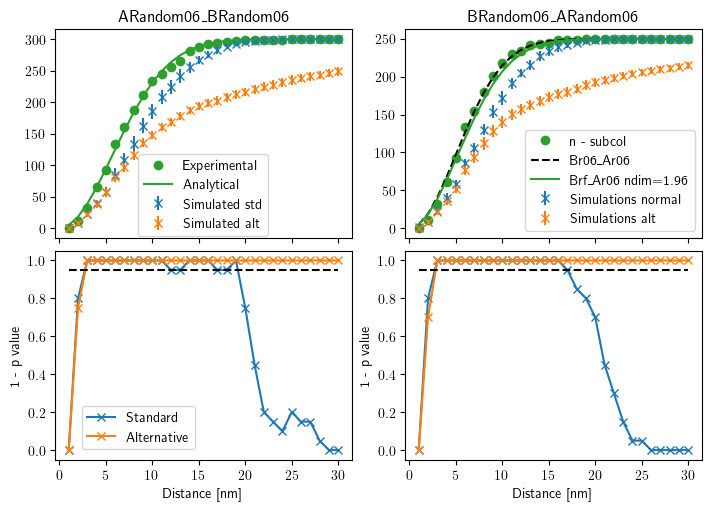

In [24]:
names = ['ARandom06_BRandom06', 'BRandom06_ARandom06']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);

Ar06_Br06 = coloc_theory.coloc_random(
    distance=distance, N=(n_A, n_B), A=(rectangle_06_area, rectangle_06_area), 
    A_over=rectangle_06_area, grid=False, over_factor=0.0, ndim=1.96)
axes[0, 0].plot(distance, Ar06_Br06, '-', color='C2', label='Ar06_Br06 ndim=1.96');
axes[0, 0].legend()

Br06_Ar06 = coloc_theory.coloc_random(
    distance=distance, N=(n_B, n_A), A=(rectangle_06_area, rectangle_06_area), 
    A_over=rectangle_06_area, grid=False, over_factor=0.0, ndim=2)
axes[0, 1].plot(distance, Br06_Ar06, '--', color='k', label='Br06_Ar06');
Br06_Ar06 = coloc_theory.coloc_random(
    distance=distance, N=(n_B, n_A), A=(rectangle_06_area, rectangle_06_area), 
    A_over=rectangle_06_area, grid=False, over_factor=0.0, ndim=1.96)
axes[0, 1].plot(distance, Br06_Ar06, '-', color='C2', label='Brf_Ar06 ndim=1.96');
axes[0, 1].legend();

leg = axes[0, 0].legend(loc=(0.28, 0.01))
leg_texts = leg.get_texts()
leg_texts[0].set_text('Experimental')
leg_texts[1].set_text('Analytical')
leg_texts[2].set_text('Simulated std')
leg_texts[3].set_text('Simulated alt')
leg = axes[1, 0].legend(loc=(0.09, 0.05))
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    #axes[0, 0].get_legend().remove()
    axes[0, 1].get_legend().remove()
    #axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'global_interact/A06_B06_legend.svg')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'global_interact/A06_B06.svg')
    

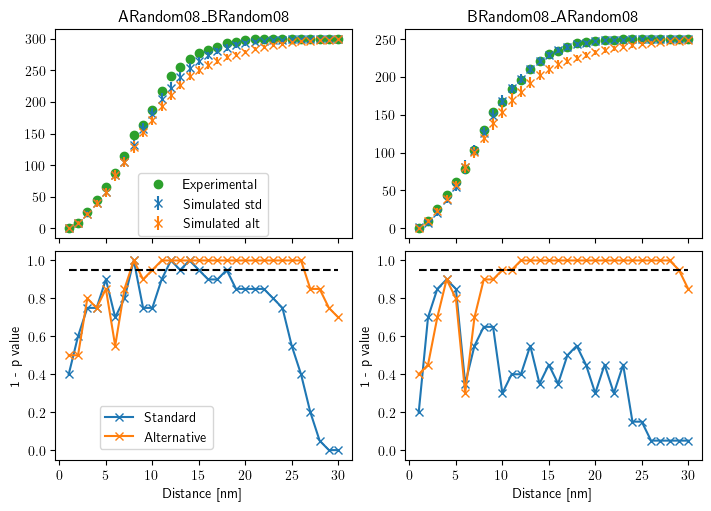

In [25]:
names = ['ARandom08_BRandom08', 'BRandom08_ARandom08']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True)

leg = axes[0, 0].legend(loc=(0.28, 0.01))
#leg = axes[0, 0].legend()
leg_texts = leg.get_texts()
leg_texts[0].set_text('Experimental')
leg_texts[1].set_text('Simulated std')
leg_texts[2].set_text('Simulated alt')
leg = axes[1, 0].legend(loc=(0.15, 0.05))
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'global_interact/A08_B08.svg')

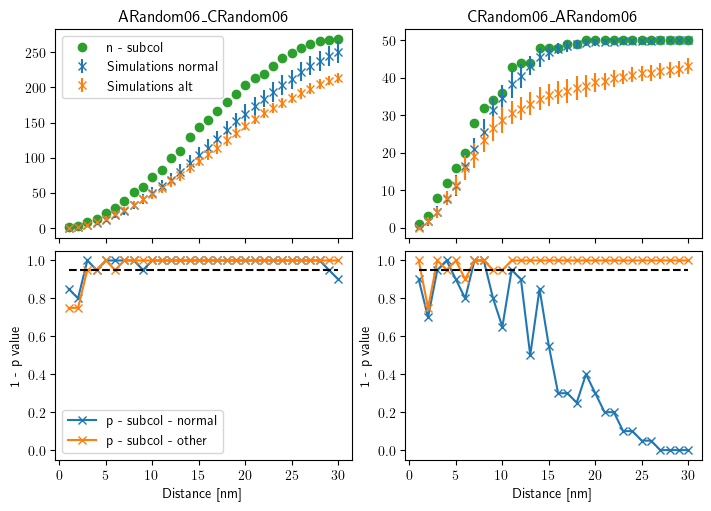

In [26]:
names = ['ARandom06_CRandom06', 'CRandom06_ARandom06']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True)

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'global_interact/A06_C06.svg')

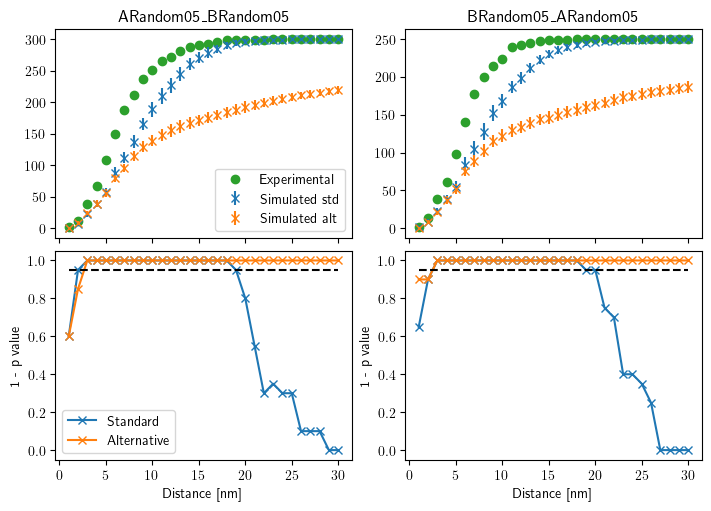

In [27]:
names = ['ARandom05_BRandom05', 'BRandom05_ARandom05']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
#fig_width = 7
fig_height_one = 2.5
#fig_height_one = 2

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True)

leg = axes[0, 0].legend()
leg.get_texts()[0].set_text('Experimental')
leg.get_texts()[1].set_text('Simulated std')
leg.get_texts()[2].set_text('Simulated alt')
leg = axes[1, 0].legend()
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'global_interact/A05_B05.svg')

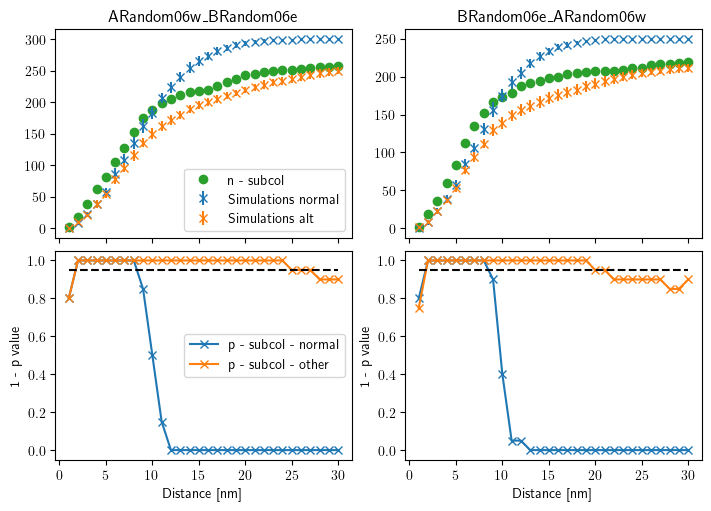

In [28]:
names = ['ARandom06w_BRandom06e', 'BRandom06e_ARandom06w']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True)

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'global_interact/A06w_B06e.svg')

### Particles

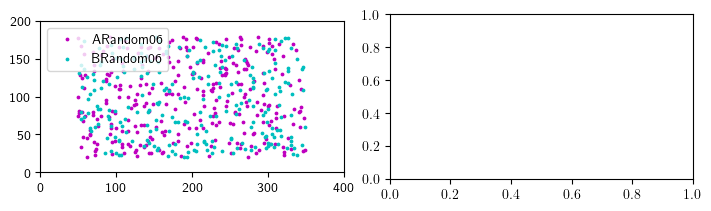

In [29]:
# Graph on the right intentionally left empty

pattern_names = [('ARandom06', 'BRandom06'), ('ARandom06', 'BRandom06')]

xlim=(100, 500)
ylim=(200, 400)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
ax = plot_pattern(
        mps=mps, names=pattern_names[0], ax=axes[0], xlim=xlim, ylim=ylim,
        colors=colors, markersize=3)
    
ax.set_xticks(ax.get_xticks(), ax.get_xticks().astype(int) - xlim[0])
ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int) - ylim[0])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect('equal', adjustable='box')

if plot_type == 'figure_save':
    axes[0].get_legend().remove()
    #axes[1].get_legend().remove()
    plt.savefig(
        plot_root + 'global_interact/A06-B06_particles.pdf', bbox_inches='tight')

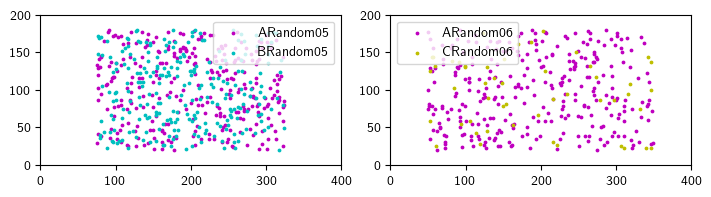

In [30]:

pattern_names = [('ARandom05', 'BRandom05'), ('ARandom06', 'CRandom06')]

xlim=(100, 500)
ylim=(200, 400)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
for ax, pattern_nam in zip(axes, pattern_names):
    _ = plot_pattern(
        mps=mps, names=pattern_nam, ax=ax, xlim=xlim, ylim=ylim,
        colors=colors, markersize=3)
    
    ax.set_xticks(ax.get_xticks(), ax.get_xticks().astype(int) - xlim[0])
    ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int) - ylim[0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')

if plot_type == 'figure_save':
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    plt.savefig(
        plot_root + 'global_interact/A05-B05_A06-C06.pdf', bbox_inches='tight')

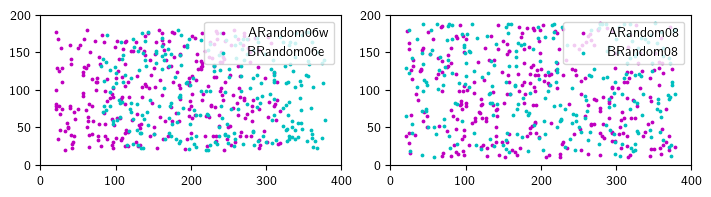

In [31]:

pattern_names = [('ARandom06w', 'BRandom06e'), ('ARandom08', 'BRandom08')]

xlim=(100, 500)
ylim=(200, 400)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
for ax, pattern_nam in zip(axes, pattern_names):
    _ = plot_pattern(
        mps=mps, names=pattern_nam, ax=ax, xlim=xlim, ylim=ylim,
        colors=colors, markersize=3)
    
    ax.set_xticks(ax.get_xticks(), ax.get_xticks().astype(int) - xlim[0])
    ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int) - ylim[0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')

if plot_type == 'figure_save':
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    plt.savefig(
        plot_root + 'global_interact/A05w-B06e_A08-B08.pdf', bbox_inches='tight')

## Local interaction

### Figures

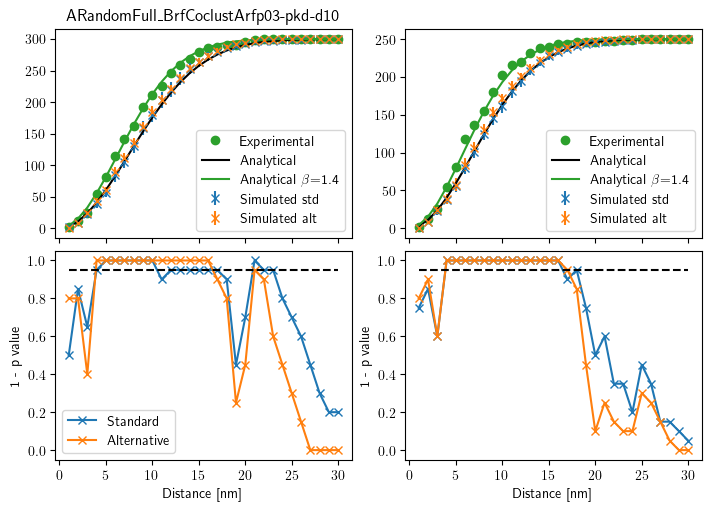

In [32]:
names = ['ARandomFull_BrfCoclustArfp03-pkd-d10', 'BrfCoclustArfp03-pkd-d10_ARandomFull']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);
axes[0, 1].set_title('');

# analytical
Arf_Brf = coloc_theory.coloc_random(
    distance=distance, N=(n_A, n_B), A=(rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=1.96)
axes[0, 0].plot(distance, Arf_Brf, '-', color='k', label='Analytical')
Arf_Brf_df = coloc_theory.coloc_random(
    distance=distance, N=(n_A, n_B), A=(rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=1.96, hood_area_factor=1.4)
axes[0, 0].plot(
    distance, Arf_Brf_df, '-', color='C2', label=r'Analytical $\beta$=1.4')
axes[0, 0].legend();

Brf_Arf = coloc_theory.coloc_random(
    distance=distance, N=(n_B, n_A), A=(rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=1.96)
axes[0, 1].plot(distance, Brf_Arf, '-', color='k', label='Analytical')
Brf_Arf_df = coloc_theory.coloc_random(
    distance=distance, N=(n_B, n_A), A=(rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=1.96, hood_area_factor=1.4)
axes[0, 1].plot(
    distance, Brf_Arf_df, '-', color='C2', label=r'Analytical $\beta$=1.4');
axes[0, 1].legend();

leg = axes[0, 0].legend()
leg.get_texts()[0].set_text('Experimental')
leg.get_texts()[3].set_text('Simulated std')
leg.get_texts()[4].set_text('Simulated alt')
leg = axes[0, 1].legend()
leg.get_texts()[0].set_text('Experimental')
leg.get_texts()[3].set_text('Simulated std')
leg.get_texts()[4].set_text('Simulated alt')
leg = axes[1, 0].legend()
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    #axes[0, 0].get_legend().remove()
    #axes[0, 1].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'local_interact/A_Bp03kd_legend.svg')

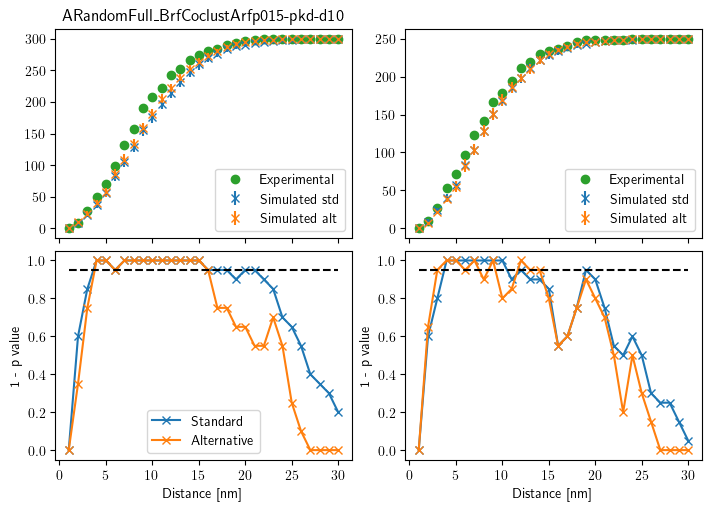

In [33]:
# Legend
names = ['ARandomFull_BrfCoclustArfp015-pkd-d10', 'BrfCoclustArfp015-pkd-d10_ARandomFull']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);
axes[0, 1].set_title('');

leg = axes[0, 0].legend()
leg.get_texts()[0].set_text('Experimental')
leg.get_texts()[1].set_text('Simulated std')
leg.get_texts()[2].set_text('Simulated alt')
leg = axes[0, 1].legend()
leg.get_texts()[0].set_text('Experimental')
leg.get_texts()[1].set_text('Simulated std')
leg.get_texts()[2].set_text('Simulated alt')
leg = axes[1, 0].legend()
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'local_interact/A_Bp015kd.svg')

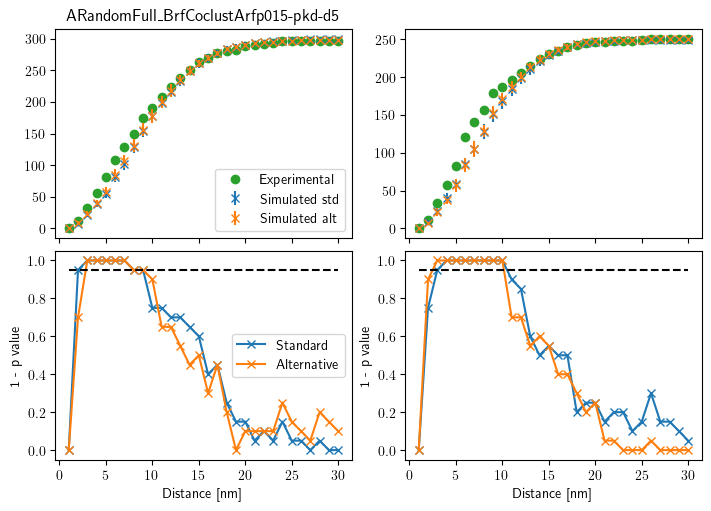

In [34]:
names = ['ARandomFull_BrfCoclustArfp015-pkd-d5', 'BrfCoclustArfp015-pkd-d5_ARandomFull']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);
axes[0, 1].set_title('');

leg = axes[0, 0].legend()
leg.get_texts()[0].set_text('Experimental')
leg.get_texts()[1].set_text('Simulated std')
leg.get_texts()[2].set_text('Simulated alt')
leg = axes[1, 0].legend()
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'local_interact/A_Bp015kd_d5.svg')

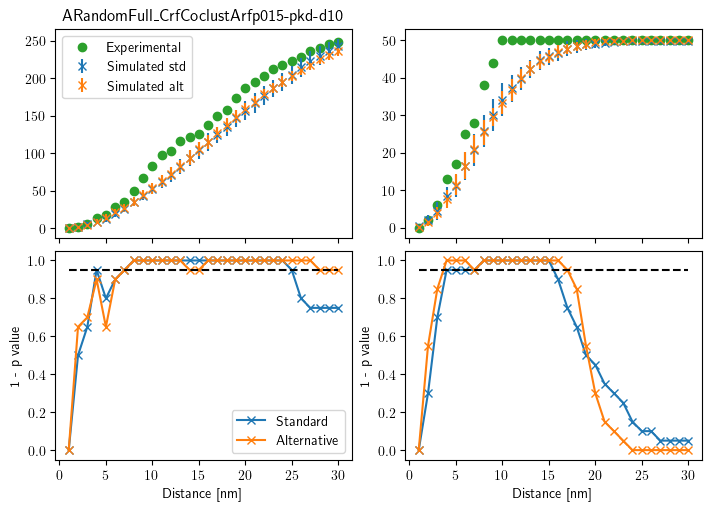

In [35]:
names = ['ARandomFull_CrfCoclustArfp015-pkd-d10', 'CrfCoclustArfp015-pkd-d10_ARandomFull']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);
axes[0, 1].set_title('');

leg = axes[0, 0].legend()
leg.get_texts()[0].set_text('Experimental')
leg.get_texts()[1].set_text('Simulated std')
leg.get_texts()[2].set_text('Simulated alt')
leg = axes[1, 0].legend()
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[0, 1].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'local_interact/A_Cp015kd.svg')

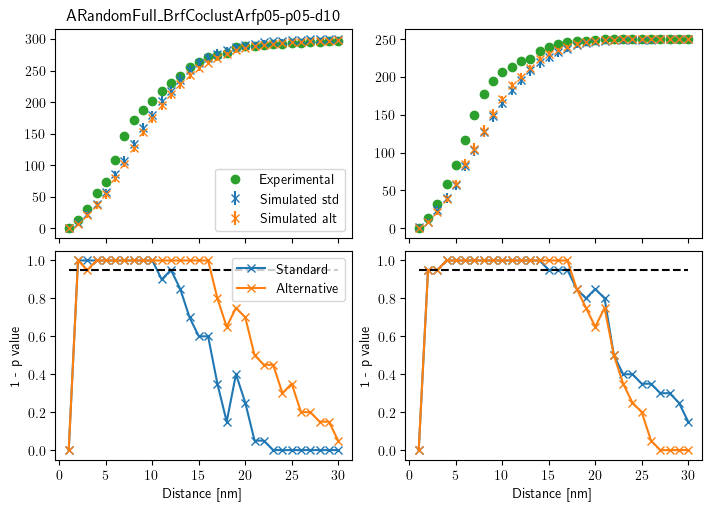

In [36]:
names = ['ARandomFull_BrfCoclustArfp05-p05-d10', 'BrfCoclustArfp05-p05-d10_ARandomFull']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);
axes[0, 1].set_title('');

leg = axes[0, 0].legend()
leg.get_texts()[0].set_text('Experimental')
leg.get_texts()[1].set_text('Simulated std')
leg.get_texts()[2].set_text('Simulated alt')
leg = axes[1, 0].legend()
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[0, 1].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'local_interact/A_Bp05p05.svg')

### Particles

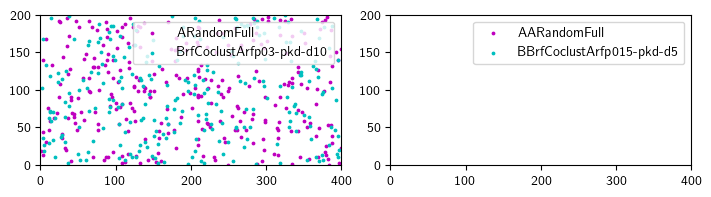

In [37]:
# Right plot intentionaly left empty

pattern_names = [
    ('ARandomFull', 'BrfCoclustArfp03-pkd-d10'), 
    ('AARandomFull', 'BBrfCoclustArfp015-pkd-d5')]

xlim=(100, 500)
ylim=(200, 400)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
for ax, pattern_nam in zip(axes, pattern_names):
    _ = plot_pattern(
        mps=mps, names=pattern_nam, ax=ax, xlim=xlim, ylim=ylim,
        colors=colors, markersize=3)
    
    ax.set_xticks(ax.get_xticks(), ax.get_xticks().astype(int) - xlim[0])
    ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int) - ylim[0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')

if plot_type == 'figure_save':
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    plt.savefig(
        plot_root + 'local_interact/A-Bp03kd.pdf', bbox_inches='tight')

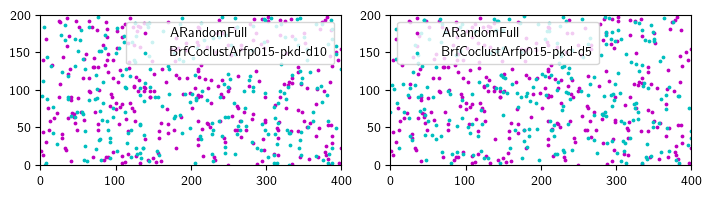

In [38]:

pattern_names = [
    ('ARandomFull', 'BrfCoclustArfp015-pkd-d10'), 
    ('ARandomFull', 'BrfCoclustArfp015-pkd-d5')]

xlim=(100, 500)
ylim=(200, 400)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
for ax, pattern_nam in zip(axes, pattern_names):
    _ = plot_pattern(
        mps=mps, names=pattern_nam, ax=ax, xlim=xlim, ylim=ylim,
        colors=colors, markersize=3)
    
    ax.set_xticks(ax.get_xticks(), ax.get_xticks().astype(int) - xlim[0])
    ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int) - ylim[0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')

if plot_type == 'figure_save':
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    plt.savefig(
        plot_root + 'local_interact/A-Bp015kd_d10_d5.pdf', bbox_inches='tight')

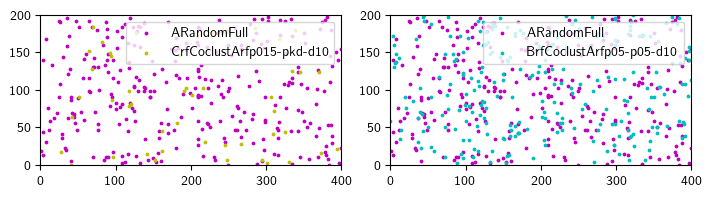

In [39]:

pattern_names = [
    ('ARandomFull', 'CrfCoclustArfp015-pkd-d10'), 
    ('ARandomFull', 'BrfCoclustArfp05-p05-d10')]

xlim=(100, 500)
ylim=(200, 400)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
for ax, pattern_nam in zip(axes, pattern_names):
    _ = plot_pattern(
        mps=mps, names=pattern_nam, ax=ax, xlim=xlim, ylim=ylim,
        colors=colors, markersize=3)
    
    ax.set_xticks(ax.get_xticks(), ax.get_xticks().astype(int) - xlim[0])
    ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int) - ylim[0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')

if plot_type == 'figure_save':
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    plt.savefig(
        plot_root + 'local_interact/A-Cp015kd_A-Bp05p05.pdf', bbox_inches='tight')

## Local and global interaction

### Figures

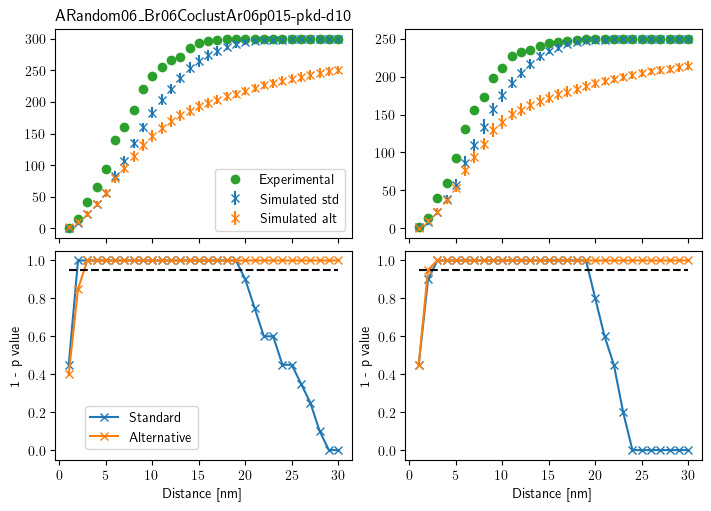

In [40]:
names = ['ARandom06_Br06CoclustAr06p015-pkd-d10', 'Br06CoclustAr06p015-pkd-d10_ARandom06']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);
axes[0, 1].set_title('');

leg = axes[0, 0].legend()
leg.get_texts()[0].set_text('Experimental')
leg.get_texts()[1].set_text('Simulated std')
leg.get_texts()[2].set_text('Simulated alt')
leg = axes[1, 0].legend(loc=(0.1, 0.05))
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'local-global_interact/A06_B06p015kd.svg')

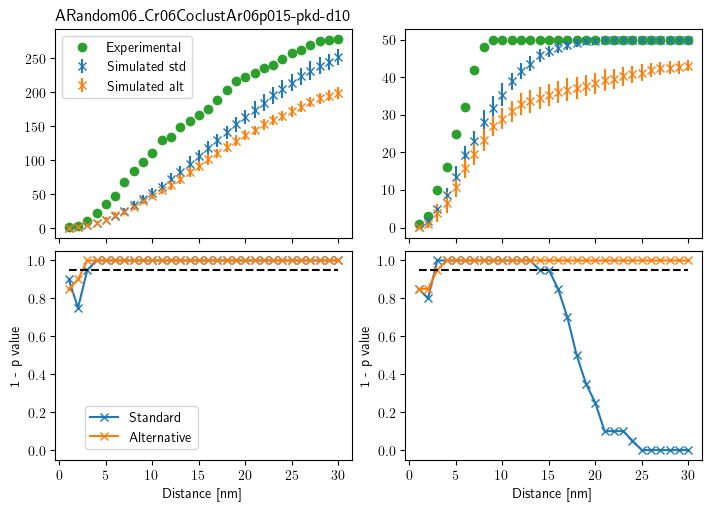

In [41]:
names = ['ARandom06_Cr06CoclustAr06p015-pkd-d10', 'Cr06CoclustAr06p015-pkd-d10_ARandom06']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);
axes[0, 1].set_title('');

leg = axes[0, 0].legend()
leg.get_texts()[0].set_text('Experimental')
leg.get_texts()[1].set_text('Simulated std')
leg.get_texts()[2].set_text('Simulated alt')
leg = axes[1, 0].legend(loc=(0.1, 0.05))
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + 'local-global_interact/A06_C06p015kd.svg')

### Particles

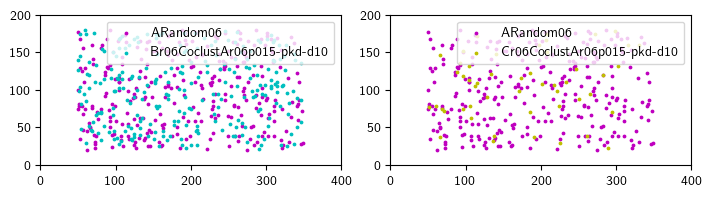

In [42]:

pattern_names = [
    ('ARandom06', 'Br06CoclustAr06p015-pkd-d10'), 
    ('ARandom06', 'Cr06CoclustAr06p015-pkd-d10')]

xlim=(100, 500)
ylim=(200, 400)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
for ax, pattern_nam in zip(axes, pattern_names):
    _ = plot_pattern(
        mps=mps, names=pattern_nam, ax=ax, xlim=xlim, ylim=ylim,
        colors=colors, markersize=3)
    
    ax.set_xticks(ax.get_xticks(), ax.get_xticks().astype(int) - xlim[0])
    ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int) - ylim[0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')

if plot_type == 'figure_save':
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    plt.savefig(
        plot_root + 'local-global_interact/A-BC-06_p015kd_d10_d5.pdf', bbox_inches='tight')

## 3-colocalization

### Random

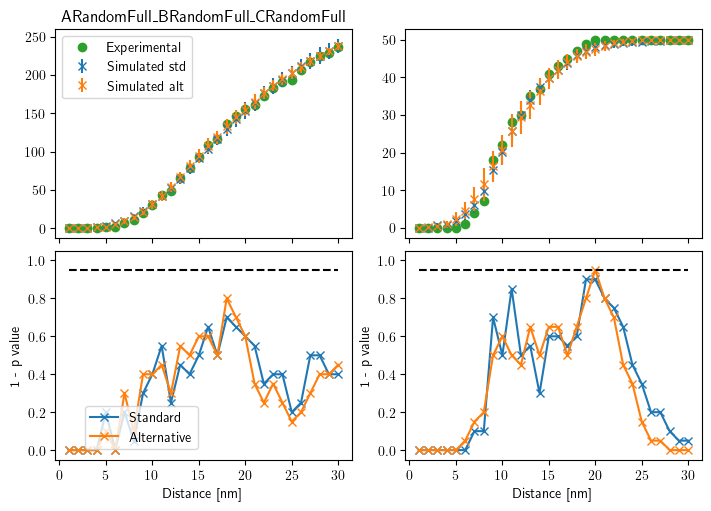

In [43]:
names = [
    'ARandomFull_BRandomFull_CRandomFull',
    'CRandomFull_ARandomFull_BRandomFull']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);
axes[0, 1].set_title('');

leg = axes[0, 0].legend()
leg.get_texts()[0].set_text('Experimental')
leg.get_texts()[1].set_text('Simulated std')
leg.get_texts()[2].set_text('Simulated alt')
leg = axes[1, 0].legend(loc=(0.1, 0.05))
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + '3-coloc/ABC-CAB.svg')

### Local interaction

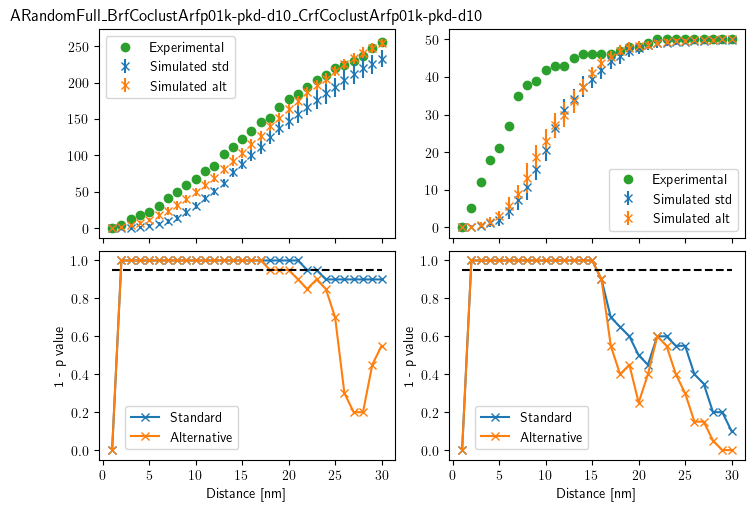

In [44]:
names = [
    'ARandomFull_BrfCoclustArfp01k-pkd-d10_CrfCoclustArfp01k-pkd-d10',
    'CrfCoclustArfp01k-pkd-d10_ARandomFull_BrfCoclustArfp01k-pkd-d10']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);
axes[0, 1].set_title('');

leg = axes[0, 0].legend()
leg_texts = leg.get_texts()
leg_texts[0].set_text('Experimental')
leg_texts[1].set_text('Simulated std')
leg_texts[2].set_text('Simulated alt')
leg = axes[1, 0].legend(loc=(0.09, 0.05))
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')
leg = axes[0, 1].legend()
leg_texts = leg.get_texts()
leg_texts[0].set_text('Experimental')
leg_texts[1].set_text('Simulated std')
leg_texts[2].set_text('Simulated alt')
leg = axes[1, 1].legend(loc=(0.09, 0.05))
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + '3-coloc/ABC-CAB_p01k-kd.svg')

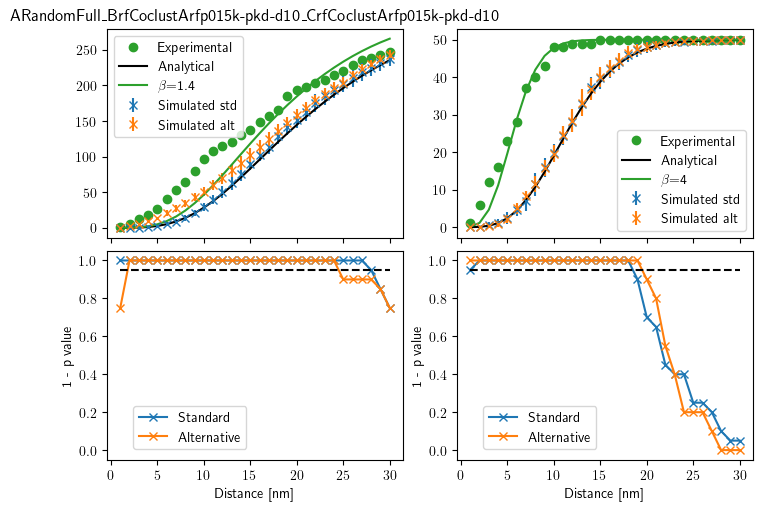

In [45]:
names = [
    'ARandomFull_BrfCoclustArfp015k-pkd-d10_CrfCoclustArfp015k-pkd-d10',
    'CrfCoclustArfp015k-pkd-d10_ARandomFull_BrfCoclustArfp015k-pkd-d10']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);
axes[0, 1].set_title('');

AFull_BFull_CFull = coloc_theory.coloc_random(
    distance=distance, N=(n_A, n_B, n_C), 
    A=(rectangle_full_area, rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=1.96)
axes[0, 0].plot(
    distance, AFull_BFull_CFull, linestyle='-', color='k', 
    label='Analytical')
AFull_BFull_CFull = coloc_theory.coloc_random(
    distance=distance, N=(n_A, n_B, n_C), 
    A=(rectangle_full_area, rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=1.96, hood_area_factor=1.4)
axes[0, 0].plot(
    distance, AFull_BFull_CFull, linestyle='-', color='C2', label=r'$\beta$=1.4')
axes[0, 0].legend();

CFull_AFull_BFull = coloc_theory.coloc_random(
    distance=distance, N=(n_C, n_A, n_B), 
    A=(rectangle_full_area, rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=1.96)
axes[0, 1].plot(
    distance, CFull_AFull_BFull, linestyle='-', color='k', 
    label='Analytical')
CFull_AFull_BFull = coloc_theory.coloc_random(
    distance=distance, N=(n_C, n_A, n_B), 
    A=(rectangle_full_area, rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=1.96, hood_area_factor=4)
axes[0, 1].plot(
    distance, CFull_AFull_BFull, linestyle='-', color='C2', label=r'$\beta$=4')
axes[0, 1].legend();

leg = axes[0, 0].legend()#loc=(1.2, 0.01))
leg_texts = leg.get_texts()
leg_texts[0].set_text('Experimental')
leg_texts[3].set_text('Simulated std')
leg_texts[4].set_text('Simulated alt')
leg = axes[1, 0].legend(loc=(0.09, 0.05))
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')
leg = axes[0, 1].legend()#loc=(1.2, 0.01))
leg_texts = leg.get_texts()
leg_texts[0].set_text('Experimental')
leg_texts[3].set_text('Simulated std')
leg_texts[4].set_text('Simulated alt')
leg = axes[1, 1].legend(loc=(0.09, 0.05))
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[0, 1].get_legend().remove()
    axes[1, 0].get_legend().remove()
    axes[1, 1].get_legend().remove()
    plt.savefig(plot_root + '3-coloc/ABC-CAB_p015k-kd.svg')

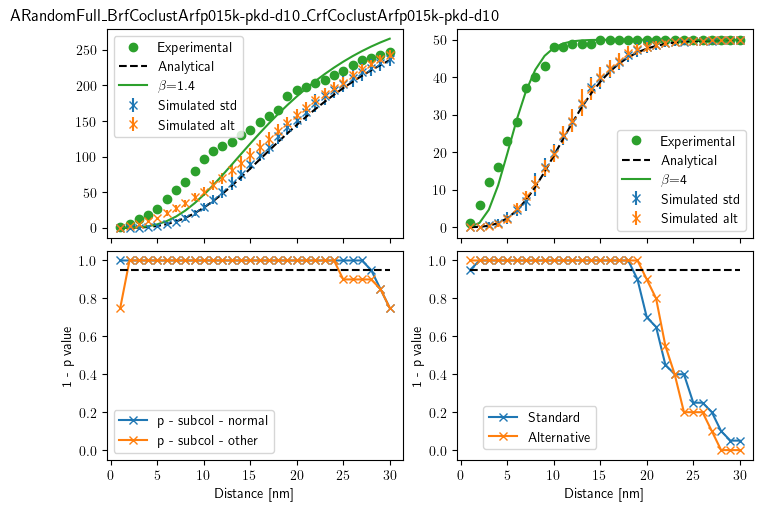

In [46]:
# Legend
names = [
    'ARandomFull_BrfCoclustArfp015k-pkd-d10_CrfCoclustArfp015k-pkd-d10',
    'CrfCoclustArfp015k-pkd-d10_ARandomFull_BrfCoclustArfp015k-pkd-d10']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);
axes[0, 1].set_title('');

AFull_BFull_CFull = coloc_theory.coloc_random(
    distance=distance, N=(n_A, n_B, n_C), 
    A=(rectangle_full_area, rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=1.96)
axes[0, 0].plot(
    distance, AFull_BFull_CFull, linestyle='--', color='k', 
    label='Analytical')
AFull_BFull_CFull = coloc_theory.coloc_random(
    distance=distance, N=(n_A, n_B, n_C), 
    A=(rectangle_full_area, rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=1.96, hood_area_factor=1.4)
axes[0, 0].plot(
    distance, AFull_BFull_CFull, linestyle='-', color='C2', label=r'$\beta$=1.4')
axes[0, 0].legend();

CFull_AFull_BFull = coloc_theory.coloc_random(
    distance=distance, N=(n_C, n_A, n_B), 
    A=(rectangle_full_area, rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=1.96)
axes[0, 1].plot(
    distance, CFull_AFull_BFull, linestyle='--', color='k', 
    label='Analytical')
CFull_AFull_BFull = coloc_theory.coloc_random(
    distance=distance, N=(n_C, n_A, n_B), 
    A=(rectangle_full_area, rectangle_full_area, rectangle_full_area), 
    A_over=rectangle_full_area, grid=False, ndim=1.96, hood_area_factor=4)
axes[0, 1].plot(
    distance, CFull_AFull_BFull, linestyle='-', color='C2', label=r'$\beta$=4')
axes[0, 1].legend();

leg = axes[0, 0].legend()#loc=(1.2, 0.01))
leg_texts = leg.get_texts()
leg_texts[0].set_text('Experimental')
#leg_texts[1].set_text('Analytical')
leg_texts[3].set_text('Simulated std')
leg_texts[4].set_text('Simulated alt')
leg = axes[0, 1].legend()#loc=(1.2, 0.01))
leg_texts = leg.get_texts()
leg_texts[0].set_text('Experimental')
#leg_texts[1].set_text('Analytical')
leg_texts[3].set_text('Simulated std')
leg_texts[4].set_text('Simulated alt')
leg = axes[1, 1].legend(loc=(0.09, 0.05))
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    #axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + '3-coloc/ABC-CAB_p015k-kd_legend.svg')

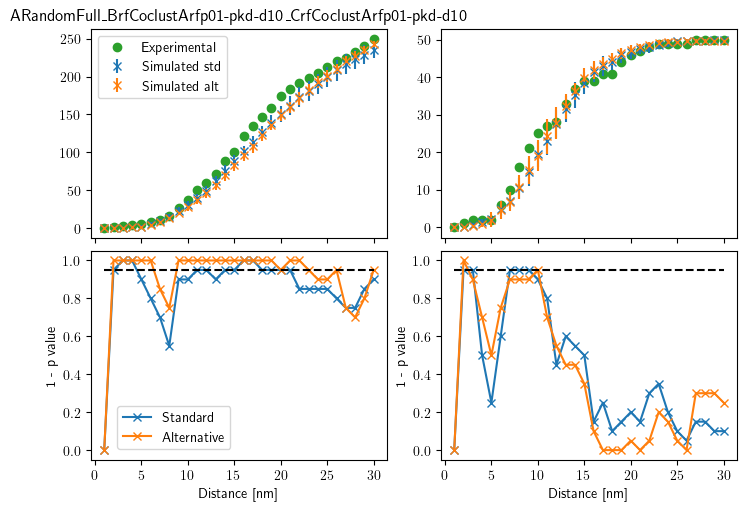

In [47]:
names = [
    'ARandomFull_BrfCoclustArfp01-pkd-d10_CrfCoclustArfp01-pkd-d10',
    'CrfCoclustArfp01-pkd-d10_ARandomFull_BrfCoclustArfp01-pkd-d10']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);
axes[0, 1].set_title('');

leg = axes[0, 0].legend()
leg_texts = leg.get_texts()
leg_texts[0].set_text('Experimental')
leg_texts[1].set_text('Simulated std')
leg_texts[2].set_text('Simulated alt')
leg = axes[1, 0].legend(loc=(0.09, 0.05))
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + '3-coloc/ABC-CAB_p01-kd.svg')

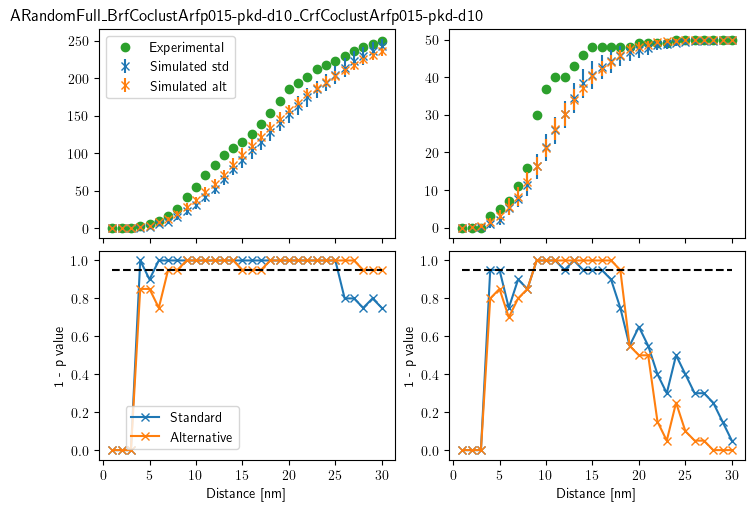

In [48]:
names = [
    'ARandomFull_BrfCoclustArfp015-pkd-d10_CrfCoclustArfp015-pkd-d10',
    'CrfCoclustArfp015-pkd-d10_ARandomFull_BrfCoclustArfp015-pkd-d10']
tomos = None
single = False
normalize = False

n_columns = 2
fig_width = 7
fig_height_one = 2.5

fig, axes = plot_multiple(
    coloc=col, names=names, normalize=normalize, n_columns=n_columns, fig_width=fig_width, 
    fig_height_one=fig_height_one, tomos=tomos, single=single, names_inner=True);
axes[0, 1].set_title('');

leg = axes[0, 0].legend()
leg_texts = leg.get_texts()
leg_texts[0].set_text('Experimental')
leg_texts[1].set_text('Simulated std')
leg_texts[2].set_text('Simulated alt')
leg = axes[1, 0].legend(loc=(0.09, 0.05))
leg.get_texts()[0].set_text('Standard')
leg.get_texts()[1].set_text('Alternative')

if plot_type == 'figure_save':
    axes[0, 0].set_title('')
    axes[0, 1].set_title('')
    axes[0, 0].set_ylabel('N colocalizations')
    axes[1, 1].set_ylabel('')
    axes[0, 0].get_legend().remove()
    axes[1, 0].get_legend().remove()
    plt.savefig(plot_root + '3-coloc/ABC-CAB_p015-kd.svg')

### Particles

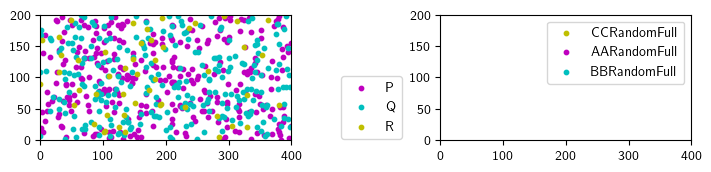

In [49]:
# Right graph intentionally left empty

pattern_names = [
    ('ARandomFull', 'BRandomFull', 'CRandomFull'), 
    ('CCRandomFull', 'AARandomFull', 'BBRandomFull')]

xlim=(100, 500)
ylim=(200, 400)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
for ax, pattern_nam in zip(axes, pattern_names):
    _ = plot_pattern(
        mps=mps, names=pattern_nam, ax=ax, xlim=xlim, ylim=ylim,
        colors=colors, markersize=10)
    
    ax.set_xticks(ax.get_xticks(), ax.get_xticks().astype(int) - xlim[0])
    ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int) - ylim[0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')

leg = axes[0].legend(['P', 'Q', 'R'], loc=(1.2, 0.01))

if plot_type == 'figure_save':
    #xes[0].get_legend().remove()
    #axes[1].get_legend().remove()
    plt.savefig(
        plot_root + '3-coloc/ABC_legend_particles.pdf', bbox_inches='tight')

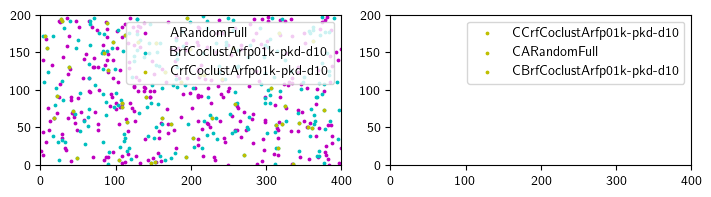

In [50]:
# Right graph intentionally left empty

pattern_names = [
    ('ARandomFull', 'BrfCoclustArfp01k-pkd-d10', 'CrfCoclustArfp01k-pkd-d10'),
    ('CCrfCoclustArfp01k-pkd-d10', 'CARandomFull', 'CBrfCoclustArfp01k-pkd-d10')]

xlim=(100, 500)
ylim=(200, 400)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
for ax, pattern_nam in zip(axes, pattern_names):
    _ = plot_pattern(
        mps=mps, names=pattern_nam, ax=ax, xlim=xlim, ylim=ylim,
        colors=colors, markersize=3)
    
    ax.set_xticks(ax.get_xticks(), ax.get_xticks().astype(int) - xlim[0])
    ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int) - ylim[0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')

if plot_type == 'figure_save':
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    plt.savefig(
        plot_root + '3-coloc/ABC-p01k_particles.pdf', bbox_inches='tight')

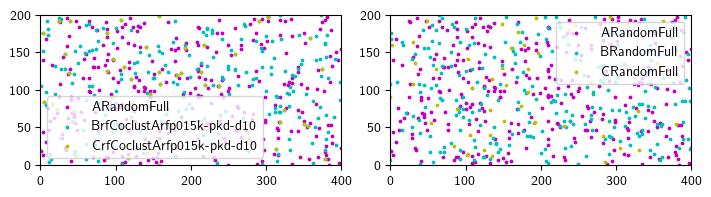

In [51]:

pattern_names = [
    ('ARandomFull', 'BrfCoclustArfp015k-pkd-d10', 'CrfCoclustArfp015k-pkd-d10'),
    ('ARandomFull', 'BRandomFull', 'CRandomFull')]

xlim=(100, 500)
ylim=(200, 400)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
for ax, pattern_nam in zip(axes, pattern_names):
    _ = plot_pattern(
        mps=mps, names=pattern_nam, ax=ax, xlim=xlim, ylim=ylim,
        colors=colors, markersize=3)
    
    ax.set_xticks(ax.get_xticks(), ax.get_xticks().astype(int) - xlim[0])
    ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int) - ylim[0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')

if plot_type == 'figure_save':
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    plt.savefig(
        plot_root + '3-coloc/ABC-p015k-random_particles.pdf', bbox_inches='tight')

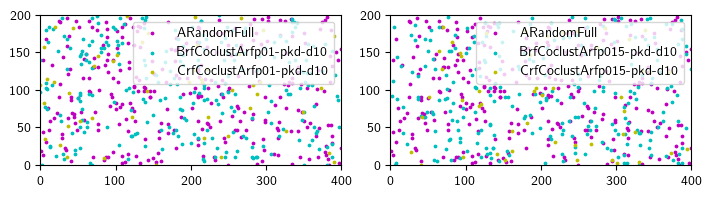

In [52]:

pattern_names = [
    ('ARandomFull', 'BrfCoclustArfp01-pkd-d10', 'CrfCoclustArfp01-pkd-d10'),
    ('ARandomFull', 'BrfCoclustArfp015-pkd-d10', 'CrfCoclustArfp015-pkd-d10')]

xlim=(100, 500)
ylim=(200, 400)
fig, axes = plt.subplots(
    1, len(pattern_names), figsize=(7, 2.), layout='constrained')
for ax, pattern_nam in zip(axes, pattern_names):
    _ = plot_pattern(
        mps=mps, names=pattern_nam, ax=ax, xlim=xlim, ylim=ylim,
        colors=colors, markersize=3)
    
    ax.set_xticks(ax.get_xticks(), ax.get_xticks().astype(int) - xlim[0])
    ax.set_yticks(ax.get_yticks(), ax.get_yticks().astype(int) - ylim[0])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable='box')

if plot_type == 'figure_save':
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    plt.savefig(
        plot_root + '3-coloc/ABC_p01-p015_particles.pdf', bbox_inches='tight')